# Libraries and Drive Connection

In [1]:
import os
import zipfile
import shutil
import urllib.request
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    cohen_kappa_score, precision_recall_fscore_support, accuracy_score
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D,
    MaxPooling2D, Input, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.applications import (
    VGG16, VGG19, InceptionV3, Xception, MobileNetV2, DenseNet121,
    DenseNet169, NASNetMobile, InceptionResNetV2
)

# Drive Connection
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Settings and File Paths

In [2]:
class Config:
    SEED = 42
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    EPOCHS = 100
    STOP_PATIENCE = 8     # Early Stopping Patience
    LR_PATIENCE = 3       # Reduce Learning Rate Patience
    LEARNING_RATE = 1e-4
    MINIMUM_LR = 1e-6     # Minimum Learning Rate


class Paths:
    DRIVE = '/content/drive'
    ROOT = os.path.join(DRIVE, 'MyDrive/Colab_Output/CRCCD_BENCHMARKING')
    RAW = os.path.join(ROOT, 'raw_data')
    OUTPUTS = os.path.join(ROOT, 'models_and_plots')
    URL = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/2pybr7f7yc-2.zip'

    @classmethod
    def setup(cls):
        for path in [cls.ROOT, cls.RAW, cls.OUTPUTS]:
            os.makedirs(path, exist_ok=True)
            print(f"Folder ready: {path}")


def seed_everything(seed=Config.SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)


Paths.setup()
seed_everything()

Folder ready: /content/drive/MyDrive/Colab_Output/CRCCD_BENCHMARKING
Folder ready: /content/drive/MyDrive/Colab_Output/CRCCD_BENCHMARKING/raw_data
Folder ready: /content/drive/MyDrive/Colab_Output/CRCCD_BENCHMARKING/models_and_plots


# Data Download and Preparation

In [3]:
def prepare_dataset():
    zip_path = os.path.join(Paths.RAW, "dataset.zip")
    extract_path = os.path.join(Paths.RAW, "extracted")

    # Downloading
    if not os.path.exists(zip_path):
        print("Downloading dataset...")
        urllib.request.urlretrieve(Paths.URL, zip_path)
        print("Download complete.")
    else:
        print("Zip file already exists.")

    # Extraction
    if not os.path.exists(extract_path):
        print("Extracting zip...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
    else:
        print("Data already extracted.")

    # Finding Files
    filepaths = []
    labels = []

    print("Scanning folders...")
    for root, dirs, files in os.walk(extract_path):
        images = [
            f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        if images:
            # Use folder name as class label
            class_name = os.path.basename(root)
            for img in images:
                filepaths.append(os.path.join(root, img))
                labels.append(class_name)

    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    return df


df = prepare_dataset()
print(f"Total Image Count: {len(df)}")
print(f"Classes: {df['label'].unique()}")
print(f"Class Distribution:\n{df['label'].value_counts()}")

Zip file already exists.
Data already extracted.
Scanning folders...
Total Image Count: 8750
Classes: ['ASCENDINGCOLON_ADENOCARCINOMA' 'CASIGMOID_COLON' 'CECUM'
 'COLONADENOCARCINOMA' 'ESOPHAGITIS' 'HEMORRHOID_suspected_CA_colon'
 'ILEOCECAL_GROWTH' 'POLYPS' 'PYLORUS' 'RECTADENOCARCINOMA' 'RECTGROWTH'
 'SQUAMUS_CELL_ANAL_CARCINOMA' 'ULCERATIVE_COLITIS' 'Z_LINE']
Class Distribution:
label
ASCENDINGCOLON_ADENOCARCINOMA    625
CASIGMOID_COLON                  625
CECUM                            625
COLONADENOCARCINOMA              625
ESOPHAGITIS                      625
HEMORRHOID_suspected_CA_colon    625
ILEOCECAL_GROWTH                 625
POLYPS                           625
PYLORUS                          625
RECTADENOCARCINOMA               625
RECTGROWTH                       625
SQUAMUS_CELL_ANAL_CARCINOMA      625
ULCERATIVE_COLITIS               625
Z_LINE                           625
Name: count, dtype: int64


# Data Splitting and Generators

In [4]:
# Train and Temp
train_df, temp_df = train_test_split(
    df, test_size=(Config.VAL_SIZE + Config.TEST_SIZE),
    random_state=Config.SEED, stratify=df['label']
)

# Val and Test
val_ratio = Config.VAL_SIZE / (Config.VAL_SIZE + Config.TEST_SIZE)
val_df, test_df = train_test_split(
    temp_df, test_size=(1 - val_ratio),
    random_state=Config.SEED, stratify=temp_df['label']
)

print(f"Train Set: {len(train_df)}")
print(f"Val Set:   {len(val_df)}")
print(f"Test Set:  {len(test_df)}")

# Generators (Data Augmentation for Train only)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=Config.IMG_SIZE, batch_size=Config.BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen = test_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=Config.IMG_SIZE, batch_size=Config.BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=Config.IMG_SIZE, batch_size=Config.BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(df['label'].unique())
CLASS_NAMES = list(train_gen.class_indices.keys())

Train Set: 6125
Val Set:   1312
Test Set:  1313
Found 6125 validated image filenames belonging to 14 classes.
Found 1312 validated image filenames belonging to 14 classes.
Found 1313 validated image filenames belonging to 14 classes.


# Class Distribution Plot

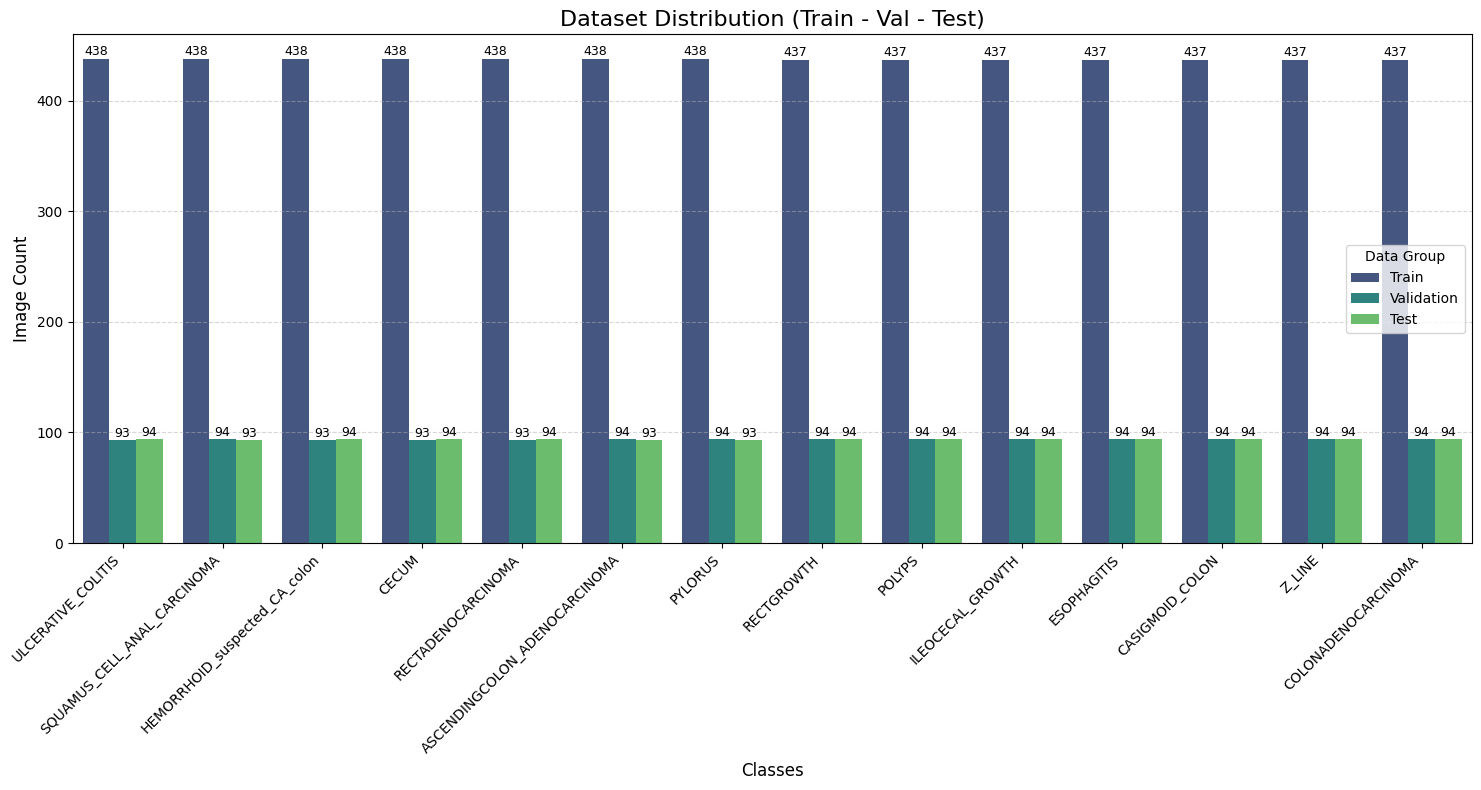

Class distribution plot saved: /content/drive/MyDrive/Colab_Output/CRCCD_BENCHMARKING/models_and_plots/class_distribution.png


In [5]:
def plot_data_distribution(train_df, val_df, test_df, save_dir):
    # Counting and Preparing Data
    train_counts = train_df['label'].value_counts().reset_index()
    train_counts.columns = ['Label', 'Count']
    train_counts['Set'] = 'Train'

    val_counts = val_df['label'].value_counts().reset_index()
    val_counts.columns = ['Label', 'Count']
    val_counts['Set'] = 'Validation'

    test_counts = test_df['label'].value_counts().reset_index()
    test_counts.columns = ['Label', 'Count']
    test_counts['Set'] = 'Test'

    # Combine all in one table
    combined_df = pd.concat([train_counts, val_counts, test_counts])

    # Plotting
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(
        data=combined_df, x='Label', y='Count', hue='Set', palette='viridis'
    )

    plt.title('Dataset Distribution (Train - Val - Test)', fontsize=16)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Image Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Write numbers on bars
    for p in ax.patches:
        if p.get_height() > 0:  # For non-empty bars
            ax.annotate(
                f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points',
                fontsize=9, rotation=0
            )

    # Saving
    plt.legend(title='Data Group')
    plt.tight_layout()
    save_path = os.path.join(save_dir, 'class_distribution.png')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Class distribution plot saved: {save_path}")


plot_data_distribution(train_df, val_df, test_df, Paths.OUTPUTS)

# Augmentation Visualization


--- Creating Augmentation Samples ---


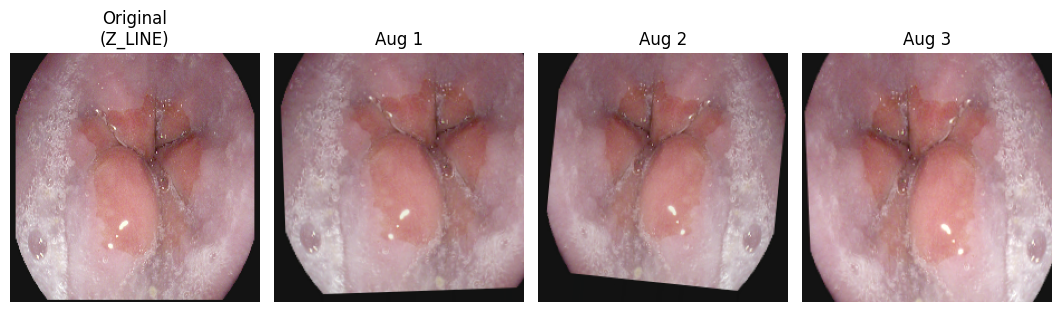

Augmentation image saved: /content/drive/MyDrive/Colab_Output/CRCCD_BENCHMARKING/models_and_plots/augmentation_samples.png


In [6]:
def visualize_augmentation(df, generator, save_dir):
    print("\n--- Creating Augmentation Samples ---")

    # Select a random image from train set
    sample_row = df.sample(1).iloc[0]
    img_path = sample_row['filepath']
    label = sample_row['label']

    # Load image and convert to array
    img = tf.keras.utils.load_img(img_path, target_size=Config.IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Visualization
    plt.figure(figsize=(16, 4))

    # Original Image
    plt.subplot(1, 6, 1)
    plt.imshow(img)
    plt.title(f"Original\n({label})")
    plt.axis('off')

    # Augmented Images
    i = 0
    for batch in generator.flow(x, batch_size=1):
        plt.subplot(1, 6, i + 2)
        plt.imshow(batch[0])
        plt.title(f"Aug {i+1}")
        plt.axis('off')

        i += 1
        if i >= 3:  # Stop after 3 samples
            break

    plt.tight_layout()
    save_path = os.path.join(save_dir, 'augmentation_samples.png')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Augmentation image saved: {save_path}")


# Call function
visualize_augmentation(train_df, train_datagen, Paths.OUTPUTS)

# Model Definitions and Plot Helper Function

In [7]:
# Model List
TRANSFER_MODELS = {
    "VGG16": VGG16,
    "VGG19": VGG19,
    "InceptionV3": InceptionV3,
    "Xception": Xception,
    "MobileNetV2": MobileNetV2,
    "DenseNet121": DenseNet121,
    "DenseNet169": DenseNet169,
    "NASNetMobile": NASNetMobile,
    "InceptionResNetV2": InceptionResNetV2
}


def build_transfer_model(base_model_func, name):
    base_model = base_model_func(
        weights='imagenet', include_top=False,
        input_shape=Config.IMG_SIZE + (3,)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions, name=name)
    model.compile(
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        loss='categorical_crossentropy', metrics=['accuracy']
    )
    return model


def build_custom_model():
    model = Sequential([
        Input(shape=Config.IMG_SIZE + (3,)),

        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Vectorization
        GlobalAveragePooling2D(),

        # Classification
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ], name="OzNET")

    model.compile(
        optimizer=Adam(learning_rate=Config.LEARNING_RATE),
        loss='categorical_crossentropy', metrics=['accuracy']
    )
    return model


def save_individual_plots(history, y_true, y_pred, y_prob, model_name, save_dir):
    # Accuracy & Loss Graph
    if history is not None:
        try:
            plt.figure(figsize=(14, 6))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='Train Acc')
            plt.plot(history.history['val_accuracy'], label='Val Acc')
            plt.title(f'{model_name} Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Train Loss')
            plt.plot(history.history['val_loss'], label='Val Loss')
            plt.title(f'{model_name} Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, 'acc_loss_graph.png'))
            plt.close()
        except Exception as e:
            print(f":: Warning: History data could not be read ({e})")
    else:
        print(
            f":: Info: Acc/loss graph skipped because '{model_name}' was loaded."
        )

    # --- CONFUSION MATRIX ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
        annot_kws={"size": 12}
    )

    plt.title(f'{model_name} Confusion Matrix', fontsize=14, pad=20)
    plt.ylabel('True Class', fontsize=12, labelpad=10)
    plt.xlabel('Predicted Class', fontsize=12, labelpad=10)

    # Rotate and align labels
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Increase left and bottom margin
    # Decrease right and top margin
    plt.subplots_adjust(left=0.20, bottom=0.20, right=0.95, top=0.90)

    # Remove unnecessary white space
    plt.savefig(
        os.path.join(save_dir, 'confusion_matrix.png'), bbox_inches='tight'
    )
    plt.close()

    # --- ROC CURVE ---
    plt.figure(figsize=(12, 8))
    y_true_dummies = pd.get_dummies(y_true).values
    colors = plt.cm.tab10(np.linspace(0, 1, len(CLASS_NAMES)))

    for i, class_label in enumerate(CLASS_NAMES):
        # Plot ROC curve only for that class
        if i < y_prob.shape[1]:
            fpr, tpr, _ = roc_curve(y_true_dummies[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(
                fpr, tpr, color=colors[i], lw=2,
                label=f'{class_label} (AUC = {roc_auc:.2f})'
            )

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} ROC Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'), bbox_inches='tight')
    plt.close()

# Training Loop (9 Transfer + 1 Custom)

In [8]:
all_results = []
comparison_data = []

# --- TRANSFER LEARNING MODELS ---
for name, model_func in TRANSFER_MODELS.items():
    print(f"\n{'='*40}\nCHECKING: {name}\n{'='*40}")

    model_dir = os.path.join(Paths.OUTPUTS, name)
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'best_{name}.keras')

    # Reset variables
    history = None
    model = None

    # --- SMART CHECK ---
    if os.path.exists(model_path):
        print(f":: {name} found in Drive! Skipping training, loading model...")
        try:
            model = load_model(model_path)
        except Exception:
            print(f":: File corrupted, {name} will be retrained.")
            model = None

    # --- TRAINING ---
    if model is None:
        print(f":: No record found for {name}. Starting training...")
        model = build_transfer_model(model_func, name)

        callbacks = [
            EarlyStopping(
                monitor='val_loss', patience=Config.STOP_PATIENCE,
                restore_best_weights=True, verbose=1
            ),
            ModelCheckpoint(
                model_path, save_best_only=True, monitor='val_accuracy'
            ),
            ReduceLROnPlateau(
                monitor='val_loss', factor=0.2, patience=Config.LR_PATIENCE,
                min_lr=Config.MINIMUM_LR, verbose=1
            )
        ]

        history = model.fit(
            train_gen, validation_data=val_gen,
            epochs=Config.EPOCHS, callbacks=callbacks, verbose=1
        )

    # --- CREATE PLOTS AND METRICS ---
    print(f":: Creating plots and metrics for {name}...")

    test_gen.reset()

    y_prob = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_gen.classes

    # Save Plots (Acc/Loss skipped if History is None, others plotted)
    save_individual_plots(history, y_true, y_pred, y_prob, name, model_dir)

    # Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    kappa = cohen_kappa_score(y_true, y_pred)

    all_results.append({
        "Model": name, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1-Score": f1, "Kappa": kappa
    })
    comparison_data.append(
        {"Model": name, "y_true": y_true, "y_prob": y_prob}
    )

    del model
    tf.keras.backend.clear_session()
    gc.collect()

# --- CUSTOM MODEL (OzNET) ---
custom_name = "OzNET"
print(f"\n{'='*40}\nCHECKING: {custom_name}\n{'='*40}")

custom_dir = os.path.join(Paths.OUTPUTS, custom_name)
# Indentation fixed here
os.makedirs(custom_dir, exist_ok=True)
custom_path = os.path.join(custom_dir, 'best_OzNET.keras')

c_history = None
c_model = None

# --- SMART CHECK ---
if os.path.exists(custom_path):
    print(f":: {custom_name} found in Drive! Loading...")
    try:
        c_model = load_model(custom_path)
    except Exception:
        print(":: Model could not be loaded, will be retrained.")
        c_model = None

# --- TRAINING ---
if c_model is None:
    print(f":: Training {custom_name}...")
    c_model = build_custom_model()

    c_callbacks = [
        EarlyStopping(
            monitor='val_loss', patience=Config.STOP_PATIENCE,
            restore_best_weights=True, verbose=1
        ),
        ModelCheckpoint(
            custom_path, save_best_only=True, monitor='val_accuracy'
        ),
        ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=Config.LR_PATIENCE,
            min_lr=Config.MINIMUM_LR, verbose=1
        )
    ]

    c_history = c_model.fit(
        train_gen, validation_data=val_gen,
        epochs=Config.EPOCHS, callbacks=c_callbacks, verbose=1
    )

# --- CREATE PLOTS AND METRICS ---
print(f":: Creating plots and metrics for {custom_name}...")

test_gen.reset()
c_prob = c_model.predict(test_gen, verbose=1)
c_pred = np.argmax(c_prob, axis=1)
c_true = test_gen.classes

# Save Plots (Overwrite)
save_individual_plots(
    c_history, c_true, c_pred, c_prob, custom_name, custom_dir
)

c_acc = accuracy_score(c_true, c_pred)
c_prec, c_rec, c_f1, _ = precision_recall_fscore_support(
    c_true, c_pred, average='weighted'
)
c_kappa = cohen_kappa_score(c_true, c_pred)

all_results.append({
    "Model": custom_name, "Accuracy": c_acc, "Precision": c_prec,
    "Recall": c_rec, "F1-Score": c_f1, "Kappa": c_kappa
})
comparison_data.append(
    {"Model": custom_name, "y_true": c_true, "y_prob": c_prob}
)

print("\n--- ALL TRAINING AND EVALUATIONS COMPLETED ---")


CHECKING: VGG16
:: VGG16 found in Drive! Skipping training, loading model...
:: Creating plots and metrics for VGG16...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 1029s 25s/step
:: Info: Acc/loss graph skipped because 'VGG16' was loaded.

CHECKING: VGG19
:: VGG19 found in Drive! Skipping training, loading model...
:: Creating plots and metrics for VGG19...
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 295ms/step
:: Info: Acc/loss graph skipped because 'VGG19' was loaded.

CHECKING: InceptionV3
:: InceptionV3 found in Drive! Skipping training, loading model...
:: Creating plots and metrics for InceptionV3...
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 412ms/step
:: Info: Acc/loss graph skipped because 'InceptionV3' was loaded.

CHECKING: Xception
:: Xception found in Drive! Skipping training, loading model...
:: Creating plots and metrics for Xception...
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step
:: Info: Acc/loss graph skipped because 'Xception' was loaded.

CHECKING: MobileNetV2
:: MobileNetV2 found in Drive! Skipping training, loading model...
:: Creating plots and metrics for MobileNetV2...
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 474ms/step
:: Info: Acc

# Comparative Plots and Reporting

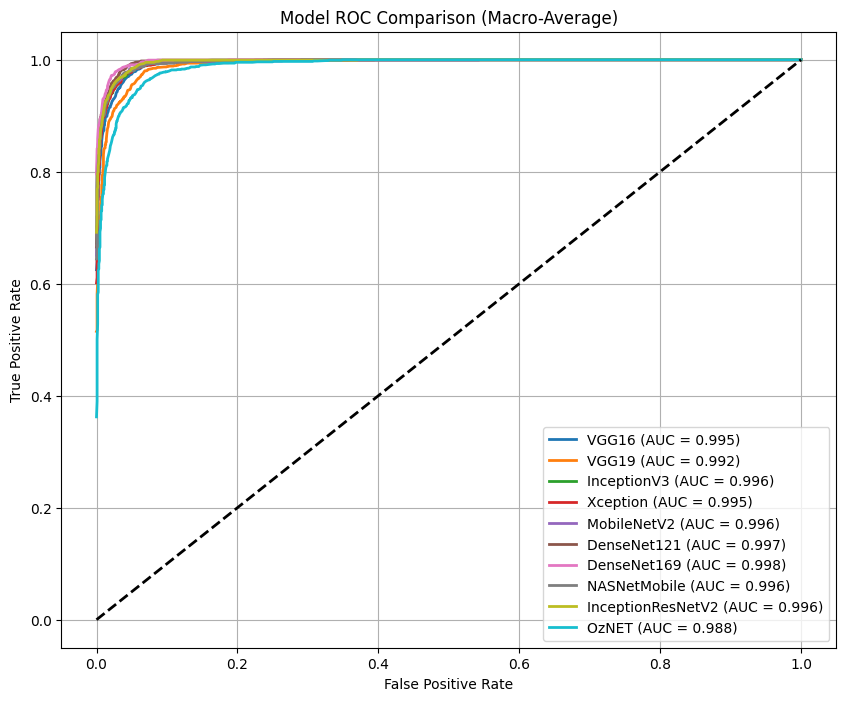

Combined ROC curve saved: /content/drive/MyDrive/Colab_Output/CRCCD_BENCHMARKING/models_and_plots/combined_roc_curve.png


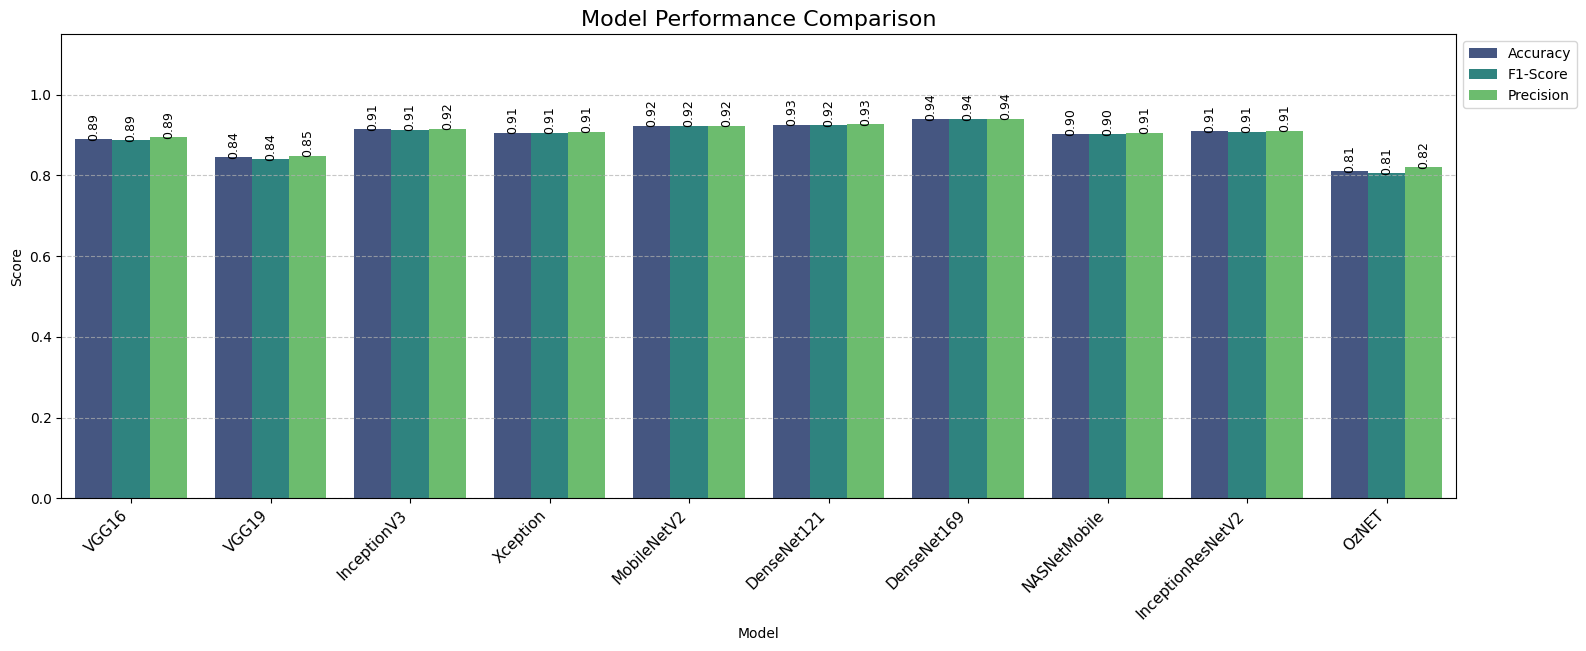

Comparison bar chart saved: /content/drive/MyDrive/Colab_Output/CRCCD_BENCHMARKING/models_and_plots/model_comparison_chart.png

--- RESULTS TABLE ---
               Model  Accuracy  Precision    Recall  F1-Score     Kappa
0              VGG16  0.890327   0.894175  0.890327  0.887676  0.881892
1              VGG19  0.844631   0.848749  0.844631  0.840349  0.832681
2        InceptionV3  0.913938   0.916246  0.913938  0.913257  0.907318
3           Xception  0.906321   0.908637  0.906321  0.905577  0.899116
4        MobileNetV2  0.923077   0.923040  0.923077  0.922844  0.917160
5        DenseNet121  0.925362   0.926655  0.925362  0.924910  0.919621
6        DenseNet169  0.939071   0.940503  0.939071  0.938814  0.934384
7       NASNetMobile  0.902513   0.905220  0.902513  0.902012  0.895014
8  InceptionResNetV2  0.909368   0.910270  0.909368  0.908710  0.902397
9              OzNET  0.811120   0.820067  0.811120  0.805602  0.796594

Project Outputs Here: /content/drive/MyDrive/Colab_Output

In [9]:
def plot_combined_roc(comp_data, save_path):
    plt.figure(figsize=(10, 8))

    for item in comp_data:
        name = item['Model']
        y_true = item['y_true']
        y_prob = item['y_prob']

        # ROC curve calculation (Macro-Average)
        y_true_dummies = pd.get_dummies(y_true).values
        n_classes = y_true_dummies.shape[1]

        # Plot overall model success by averaging FPR/TPR of all classes
        all_fpr = np.unique(np.concatenate([
            roc_curve(y_true_dummies[:, i], y_prob[:, i])[0]
            for i in range(n_classes)
        ]))
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_dummies[:, i], y_prob[:, i])
            mean_tpr += np.interp(all_fpr, fpr, tpr)

        mean_tpr /= n_classes
        roc_auc = auc(all_fpr, mean_tpr)

        plt.plot(
            all_fpr, mean_tpr, label=f'{name} (AUC = {roc_auc:.3f})',
            linewidth=2
        )

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC Comparison (Macro-Average)')
    plt.legend(loc="lower right")
    plt.grid(True)

    save_file = os.path.join(save_path, 'combined_roc_curve.png')
    plt.savefig(save_file)
    plt.show()
    plt.close()
    print(f"Combined ROC curve saved: {save_file}")


def plot_comparison_bar(results, save_path):
    df_res = pd.DataFrame(results)

    # Accuracy, F1 and Precision Comparison
    df_melted = df_res.melt(
        id_vars="Model",
        value_vars=["Accuracy", "F1-Score", "Precision"],
        var_name="Metric",
        value_name="Score"
    )

    plt.figure(figsize=(18, 8))
    sns.barplot(
        data=df_melted, x="Model", y="Score", hue="Metric", palette="viridis"
    )
    plt.title("Model Performance Comparison", fontsize=16)

    # Bottom margin to fit names
    plt.subplots_adjust(bottom=0.30)

    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.ylim(0, 1.15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for p in plt.gca().patches:
        if p.get_height() > 0:
            plt.gca().annotate(
                f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), textcoords='offset points',
                fontsize=9, rotation=90
            )

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(
        os.path.join(save_path, 'model_comparison_chart.png'),
        bbox_inches='tight'
    )
    plt.show()
    plt.close()
    print(
        f"Comparison bar chart saved: "
        f"{os.path.join(save_path, 'model_comparison_chart.png')}"
    )


# Draw Plots
plot_combined_roc(comparison_data, Paths.OUTPUTS)
plot_comparison_bar(all_results, Paths.OUTPUTS)

# Save CSV
results_df = pd.DataFrame(all_results)
csv_path = os.path.join(Paths.OUTPUTS, 'final_project_results.csv')
results_df.to_csv(csv_path, index=False)

# Show Results
print("\n--- RESULTS TABLE ---")
print(results_df)
print(f"\nProject Outputs Here: {Paths.OUTPUTS}")